IMPORTING ALL THE NECESSARY LIBRARIES



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.models import Sequential

from PIL import Image
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

BRINGING THE KAGGLE DATASET IN THE NOTEBOOK

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:00<00:00, 42.4MB/s]
100% 2.29G/2.29G [01:01<00:00, 40.4MB/s]


In [6]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [7]:
data_dir = "/content/chest_xray/chest_xray"
data_dir_train = "/content/chest_xray/chest_xray/train"
data_dir_validation = "/content/chest_xray/chest_xray/val"
data_dir_test = "/content/chest_xray/chest_xray/test"

PREPROCESSING THE DATASET IMAGES


In [8]:
from pathlib import Path
import imghdr

data_dir = "/content/chest_xray/chest_xray"
image_extensions = [".png", ".svg", ".gif", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [9]:
img_height,img_width=180, 180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 5216 files belonging to 2 classes.


In [10]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


VISUALISING THE DATASET IMAGES


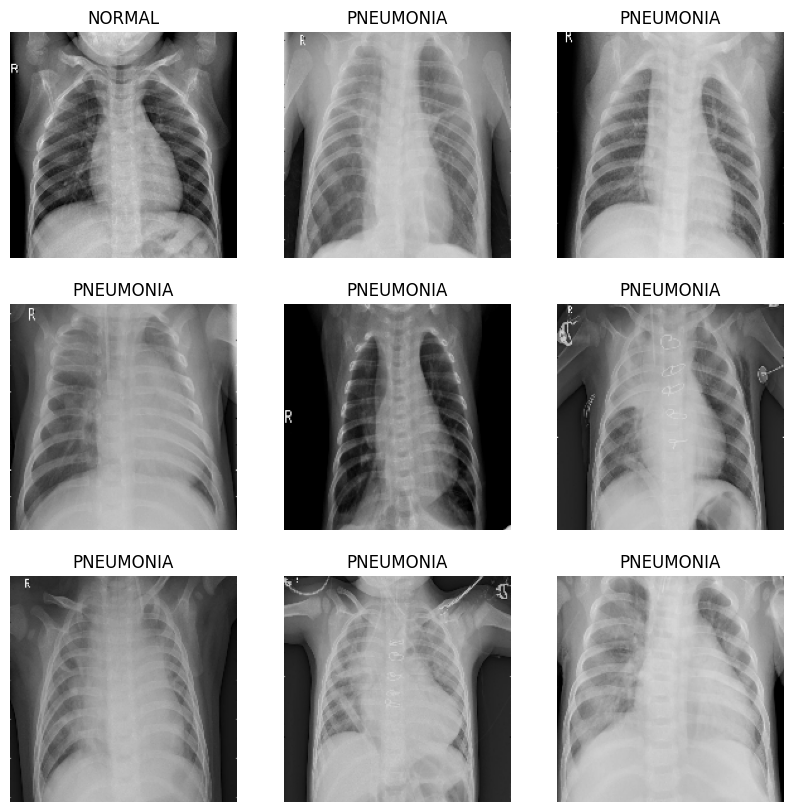

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

FINDING TOTAL NO. OF IMAGES IN BOTH THE CLASSES


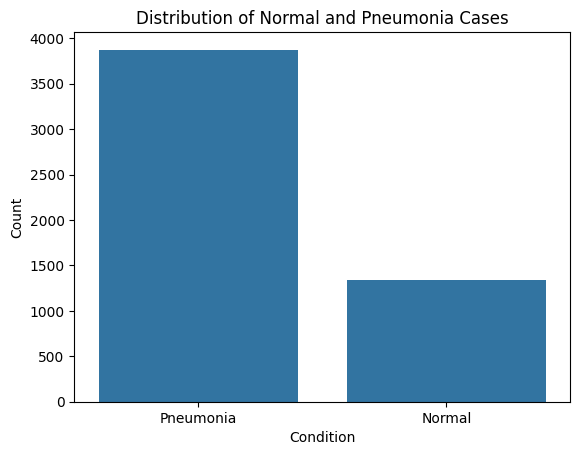

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize counters for labels
listx = []

# Iterate over the dataset and count labels
for images, labels in train_ds:
    for label in labels:
        if label == 0:
            listx.append("Normal")
        else:
            listx.append("Pneumonia")

# Create the countplot
sns.countplot(x=listx)
plt.xlabel("Condition")
plt.ylabel("Count")
plt.title("Distribution of Normal and Pneumonia Cases")
plt.show()

AUGMENTING THE TRAINING IMAGES


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_height=180
img_width=180
# Define the ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=40,  # Random rotations between 0 and 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by 20%
    height_shift_range=0.2,  # Shift images vertically by 20%
    shear_range=0.2,  # Apply random shear transformations
    zoom_range=0.2,  # Zoom images randomly
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill pixels with the nearest value after transformations
)
# Create the generators
train_ds = train_datagen.flow_from_directory(
    data_dir_train,  # Path to your training data
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

Found 5216 images belonging to 2 classes.


GENERATING THE VALIDATION DATASET

In [14]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_ds = val_datagen.flow_from_directory(
    data_dir_validation,  # Path to your validation data
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 16 images belonging to 2 classes.


GENERATING THE IMAGES OF TEST DATASET

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale images to [0, 1] range

# Create a generator for the test data
test_generator = test_datagen.flow_from_directory(
    data_dir_test,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',  # or 'categorical' for multi-class classification
    shuffle=False  # We don't shuffle test data
)

y_true = test_generator.classes


Found 624 images belonging to 2 classes.


In [16]:
# Assuming `train_ds` is your training data iterator
class_indices = train_ds.class_indices
class_names = list(class_indices.keys())

print(class_names)

['NORMAL', 'PNEUMONIA']


In [17]:
class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

USING THE PRETRAINED VGGNET MODEL

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.models import Model
base_model = VGG19(input_shape = (180,180,3),
                     include_top = False,
                     weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.inputs, output)
model_01.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 84,323,266 (321.67 MB)

 Trainable params: 64,298,882 (245.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
filepath = "model.keras"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp=ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False,mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)



model_01.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [ ]:
history_01 = model_01.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[es,cp,lrr]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 632ms/step - accuracy: 0.7555 - loss: 2.1091 - val_accuracy: 0.5625 - val_loss: 1.1377 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 121s 579ms/step - accuracy: 0.8687 - loss: 0.3052 - val_accuracy: 0.7500 - val_loss: 1.0743 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 605ms/step - accuracy: 0.9071 - loss: 0.2262 - val_accuracy: 0.7500 - val_loss: 0.5356 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 145s 616ms/step - accuracy: 0.9134 - loss: 0.2130 - val_accuracy: 0.8125 - val_loss: 0.4350 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 610ms/step - accuracy: 0.9187 - loss: 0.1963 - val_accuracy: 0.8125 - val_loss: 0.3441 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 517ms/step - accuracy: 0.9168 - loss: 0.1981 - val_accuracy: 0.7500 - val_loss: 0.7508 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.9324 - l

In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_01.save(filepath = "model_weights/vgg19_model_01.keras", overwrite=True)


In [ ]:
model_01.load_weights("model_weights/vgg19_model_01.keras")

vgg_val_eval_01 = model_01.evaluate(val_ds)
vgg_test_eval_01 = model_01.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7500 - loss: 0.9557
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.7745 - loss: 0.7829


In [ ]:
print(f"Validation Loss: {vgg_val_eval_01[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuarcy: {vgg_test_eval_01[1]}")

Validation Loss: 0.9556655287742615
Validation Accuarcy: 0.75
Test Loss: 0.48437950015068054
Test Accuarcy: 0.8637820482254028


In [ ]:
y_pred_prob = model_01.predict(test_generator)  # For flow_from_directory
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step


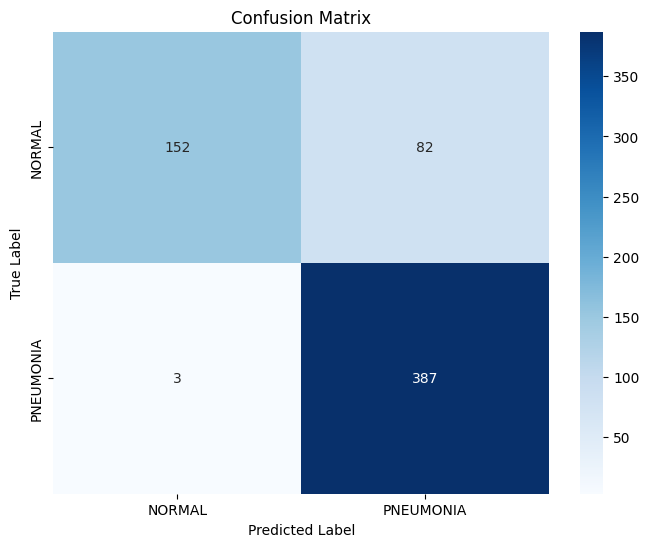

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.65      0.78       234
   PNEUMONIA       0.83      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.82      0.84       624
weighted avg       0.88      0.86      0.86       624



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report



# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
labels = ['NORMAL', 'PNEUMONIA']

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

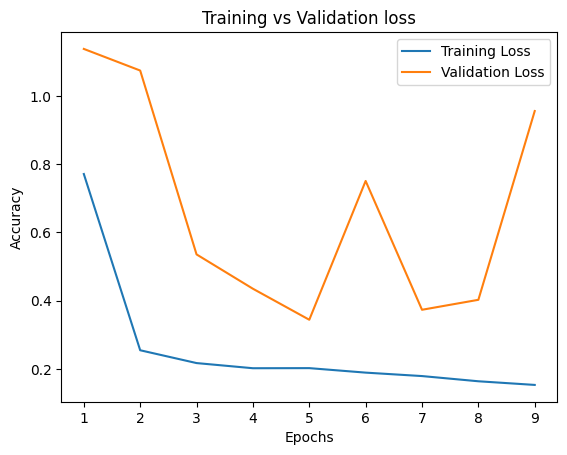

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy from history object
train_acc = history_01.history['loss']
val_acc = history_01.history['val_loss']

# Plot training vs validation accuracy
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Loss')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation loss')
plt.legend()

# Show the plot
plt.show()


 Increamental unfreezing & fine tuning

In [ ]:
base_model = VGG19(include_top=False, input_shape=(180,180,3))
base_model_layer_names = [layer.name for layer in base_model.layers]

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights("model_weights/vgg19_model_01.keras")
set_trainable = False
for layer in base_model.layers:
    if layer.name in [ 'block5_conv3','block5_conv4']:
        set_trainable=True
    if set_trainable:
        set_trainable=True
    else:
        set_trainable=False
print(model_02.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 84,323,266 (321.67 MB)

 Trainable params: 84,323,266 (321.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model_02.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history_02 = model_02.fit(train_ds,

            epochs=20,
            callbacks=[es, cp, lrr],
            validation_data=val_ds)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


163/163 ━━━━━━━━━━━━━━━━━━━━ 149s 640ms/step - accuracy: 0.7304 - loss: 40.7749 - val_accuracy: 0.5625 - val_loss: 0.7324 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 165s 632ms/step - accuracy: 0.7362 - loss: 0.5748 - val_accuracy: 0.5000 - val_loss: 0.8239 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 625ms/step - accuracy: 0.7560 - loss: 0.5578 - val_accuracy: 0.5000 - val_loss: 0.8428 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.7348 - loss: 0.5801
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 646ms/step - accuracy: 0.7349 - loss: 0.5801 - val_accuracy: 0.5000 - val_loss: 0.8226 - learning_rate: 0.0010
Epoch 4: early stopping


In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_02.save(filepath = "model_weights/vgg19_model_02.keras", overwrite=True)

In [ ]:
model_02.load_weights("model_weights/vgg19_model_02.keras")

vgg_val_eval_02 = model_02.evaluate(val_ds)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print(f"Validation Loss: {vgg_val_eval_02[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_02[1]}")
print(f"Test Loss: {vgg_test_eval_02[0]}")
print(f"Test Accuarcy: {vgg_test_eval_02[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5000 - loss: 0.8226
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.2984 - loss: 1.0321
Validation Loss: 0.8225829601287842
Validation Accuarcy: 0.5
Test Loss: 0.692623496055603
Test Accuarcy: 0.625


In [ ]:
y_pred_prob = model_02.predict(test_generator)  # For flow_from_directory
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step


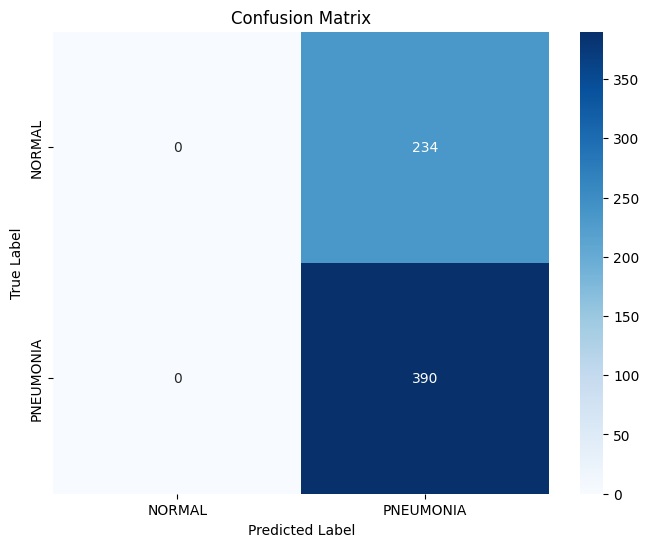

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report



# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
labels = ['NORMAL', 'PNEUMONIA']

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

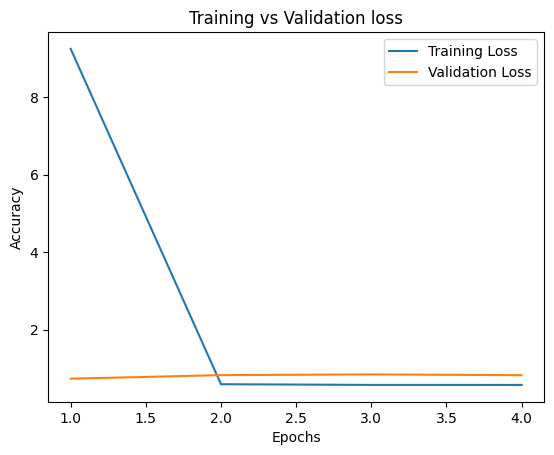

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy from history object
train_acc = history_02.history['loss']
val_acc = history_02.history['val_loss']

# Plot training vs validation accuracy
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Loss')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation loss')
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Unfreezing and fine tuning the entire network

# Unfreezing and fine tuning the entire network

In [ ]:
base_model = VGG19(include_top=False, input_shape=(180,180,3))

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights("model_weights/vgg19_model_02.keras")

print(model_03.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 84,323,266 (321.67 MB)

 Trainable params: 84,323,266 (321.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model_03.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history_03 = model_03.fit(train_ds,

            epochs=20,
            callbacks=[es, cp, lrr],
            validation_data=val_ds)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 644ms/step - accuracy: 0.7437 - loss: 0.5717 - val_accuracy: 0.5000 - val_loss: 0.8098 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 633ms/step - accuracy: 0.7372 - loss: 0.5780 - val_accuracy: 0.5000 - val_loss: 0.8749 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 630ms/step - accuracy: 0.7430 - loss: 0.5735 - val_accuracy: 0.5000 - val_loss: 0.7885 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.7443 - loss: 0.5712
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 643ms/step - accuracy: 0.7443 - loss: 0.5712 - val_accuracy: 0.5000 - val_loss: 0.8026 - learning_rate: 0.0010
Epoch 4: early stopping


In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_02.save(filepath = "model_weights/vgg19_model_03.keras", overwrite=True)

In [ ]:
model_02.load_weights("model_weights/vgg19_model_03.keras")

vgg_val_eval_02 = model_02.evaluate(val_ds)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print(f"Validation Loss: {vgg_val_eval_02[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_02[1]}")
print(f"Test Loss: {vgg_test_eval_02[0]}")
print(f"Test Accuarcy: {vgg_test_eval_02[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5000 - loss: 0.8226
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.2984 - loss: 1.0321
Validation Loss: 0.8225829601287842
Validation Accuarcy: 0.5
Test Loss: 0.692623496055603
Test Accuarcy: 0.625


In [ ]:
y_pred_prob = model_03.predict(test_generator)  # For flow_from_directory
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report



# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
labels = ['NORMAL', 'PNEUMONIA']

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

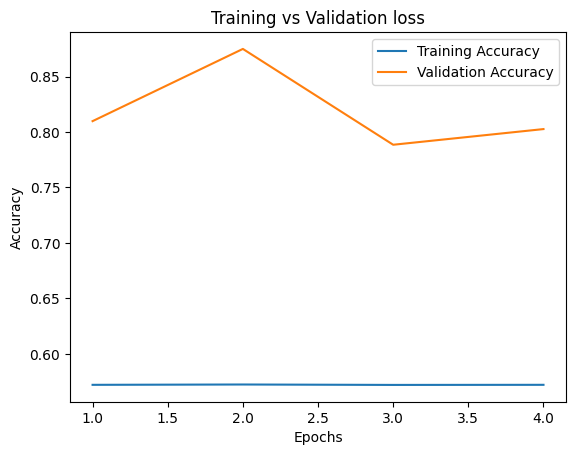

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy from history object
train_acc = history_03.history['loss']
val_acc = history_03.history['val_loss']

# Plot training vs validation accuracy
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation loss')
plt.legend()

# Show the plot
plt.show()


#Training with our custom model

In [18]:
# Define model parameters
img_height = 180
img_width = 180
num_classes = 2

# Build the model
model = Sequential([
    # No need for rescaling here since it's done in ImageDataGenerator
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),  # Dropout after pooling to prevent overfitting

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),  # Dropout after pooling

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),  # Dropout after pooling

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),  # Dropout after pooling

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Dropout in fully connected layer

    layers.Dense(num_classes, activation='softmax')  # Output layer with softmax for multi-class classification
])

# Model summary to inspect layers and parameters
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 22, 22, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,982,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 2,081,762 (7.94 MB)

 Trainable params: 2,081,026 (7.94 MB)

 Non-trainable params: 736 (2.88 KB)

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    patience=5,  # Number of epochs with no improvement
    restore_best_weights=True  # Restore weights from the best epoch
)

history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 533ms/step - accuracy: 0.8753 - loss: 0.2874 - val_accuracy: 0.5000 - val_loss: 62.9030
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 517ms/step - accuracy: 0.8777 - loss: 0.2796 - val_accuracy: 0.5000 - val_loss: 18.1850
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 520ms/step - accuracy: 0.8966 - loss: 0.2423 - val_accuracy: 0.5000 - val_loss: 1.0081
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 521ms/step - accuracy: 0.8989 - loss: 0.2459 - val_accuracy: 0.5000 - val_loss: 39.6081
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 524ms/step - accuracy: 0.9025 - loss: 0.2393 - val_accuracy: 0.6250 - val_loss: 0.6411
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 514ms/step - accuracy: 0.9123 - loss: 0.2156 - val_accuracy: 0.5000 - val_loss: 2.0639
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 520ms/step - accuracy: 0.9232 - loss: 0.2023 - val_accuracy: 0.5000 - val_loss: 2.3973
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 519ms/step - accuracy: 0.9272 - lo

In [22]:
 #Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

# Print the accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.7899 - loss: 0.5268
Test Accuracy: 83.17%


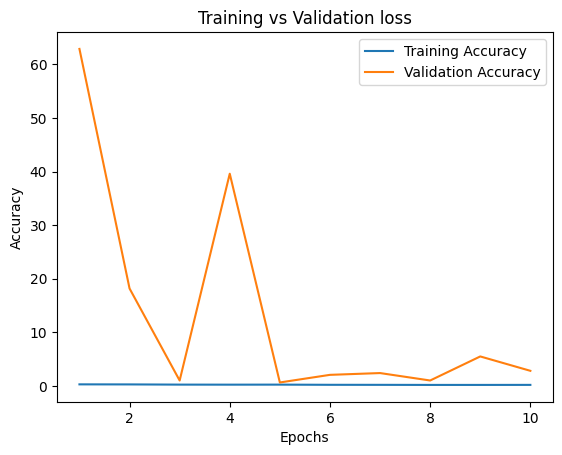

In [23]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy from history object
train_acc = history.history['loss']
val_acc = history.history['val_loss']

# Plot training vs validation accuracy
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation loss')
plt.legend()

# Show the plot
plt.show()


In [24]:
y_pred_prob = model.predict(test_generator)  # For flow_from_directory
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 295ms/step


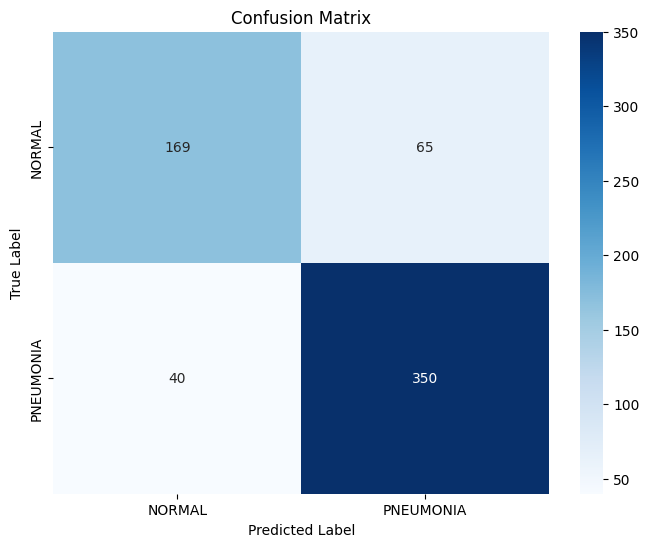

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.81      0.72      0.76       234
   PNEUMONIA       0.84      0.90      0.87       390

    accuracy                           0.83       624
   macro avg       0.83      0.81      0.82       624
weighted avg       0.83      0.83      0.83       624



In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report



# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
labels = ['NORMAL', 'PNEUMONIA']

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

In [ ]:
import tensorflow
tensorflow.keras.models.save_model(model,'xray_model.hdf5')